# Example for building an activity prediction model for the kinase ABL1

In [46]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import recall_score, cohen_kappa_score, roc_auc_score

### Helper functions

In [12]:
class FP:
    """
    Molecular fingerprint class that packs fingerprints in pandas df

    Parameters
    ----------
    fp : np.array
        Features stored in numpy array
    """
    def __init__(self, fp):
        self.fp = fp
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_fp(mol):
    """
    Generate concatenated connectivity- and feature-based RDKit Morgan fingerprint
    with fixed length and radius
    
    Parameters
    ----------
    mol : ROMol
        Input molecule
        
    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    info = {}
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=4096,
                                               useFeatures=False, bitInfo=info)
    DataStructs.ConvertToNumpyArray(fp, arr)
    arr = np.array([len(info[x]) if x in info else 0 for x in range(4096)])
    
    info2 = {}
    arr2 = np.zeros((1,))
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=4096,
                                                useFeatures=True, bitInfo=info2)
    DataStructs.ConvertToNumpyArray(fp2, arr2)
    arr2 = np.array([len(info2[x]) if x in info2 else 0 for x in range(4096)])
    
    fp_out = np.concatenate([arr, arr2])
    return FP(fp_out)

In [13]:
def get_binary_class(x, threshold=6.3):
    """
    For binarization of (pIC50) data. 6.3 corresponds to 500 nM
    """
    if np.isnan(x):
        return None
    elif x < threshold:
        return 0
    else:
        return 1

### Data preparation

In [14]:
df = pd.read_csv("ABL1.csv", index_col=0)

In [15]:
df.head()

ABL1                                            smiles
0  5.599999                       Brc1ccc2cnc(Nc3ccncn3)cc2c1
1  6.199998                     Brc1cnc2[nH]cc(-c3ccccc3)c2c1
2  6.199998     C#Cc1cc2c(cc1OC)-c1[nH]nc(-c3ccc(C#N)nc3)c1C2
3  5.539102  C#Cc1cccc(Nc2ncnc3cc(OC)c(OCCCCCCC(=O)NO)cc23)c1
4  5.562959  C#Cc1cccc(Nc2ncnc3ccc(OCCCCNCCS(C)(=O)=O)cc23)c1

In [16]:
df['ABL1'] = df['ABL1'].astype(float)

Remove lines without compound information (SMILES)

In [17]:
df = df[~df.smiles.isnull()]

Build ROMol objects

In [18]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

Remove compounds where molecule object construction failed

In [19]:
df = df[~df.ROMol.isnull()]

Remove salts and recreate SMILES

In [20]:
PandasTools.RemoveSaltsFromFrame(df)
df['smiles'] = df['ROMol'].map(Chem.MolToSmiles)

In [21]:
df.shape

(2323, 3)

ABL1                         smiles  \
0  5.599999    Brc1ccc2cnc(Nc3ccncn3)cc2c1   
1  6.199998  Brc1cnc2[nH]cc(-c3ccccc3)c2c1   

                                               ROMol  
0  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
1  <img src="data:image/png;base64,iVBORw0KGgoAAA...
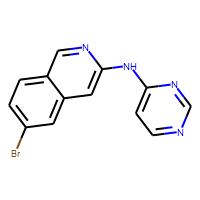
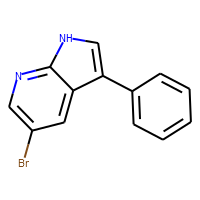

In [22]:
df.head(2)

Calculate fingerprints and store in data frame

In [23]:
df['fp'] = df.apply(lambda x: get_fp(x['ROMol']), axis=1)

### Generation of machine learning models

Define X variable (fingerprint data)

In [24]:
X = np.array([x.fp for x in df.fp])

In [25]:
X.shape

(2323, 8192)

Extract target values (y) form data frame and binarize at pIC50 = 6.3

In [26]:
y = np.array([get_binary_class(yi, threshold=6.3) for yi in df['ABL1'].values])

In [27]:
y.shape

(2323,)

Count actives in data set

In [28]:
sum(y)

621

### Validation: 5-fold cross-validation of random forest classifier

In [38]:
# Create index arrays for 5-fold cross-validation split
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Initialize variables
sens     = np.array([])
spec     = np.array([])
mean_auc = np.array([])
kappa    = np.array([])

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    
for train, test in skf.split(X, y):
    # Split data to training and test set
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]    

    # Random undersampling of training set
#     US = RandomUnderSampler(ratio=1., replacement=False)
#     X_train, y_train = US.fit_sample(X_train, y_train)
    
    # Random undersampling of test set
#     US = RandomUnderSampler(ratio=1., replacement=False)
#     X_test, y_test = US.fit_sample(X_test, y_test)
    
    # Training of random forest classifier
    clf = RandomForestClassifier(n_estimators=2500, max_features='log2',
                                 class_weight='balanced', n_jobs=1)
    clf.fit(X_train, y_train)
    
    # Prediction of test set
    y_pred       = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test).T[1]
    
    # Saving validation parameters
    # Criteria: AUC, sensitiviy, specificity and kappa
    sens = np.append(sens, recall_score(y_test, y_pred, pos_label=1))
    spec = np.append(spec, recall_score(y_test, y_pred, pos_label=0))
    mean_auc = np.append(mean_auc, roc_auc_score(y_test, y_pred_proba))
    kappa = np.append(kappa, cohen_kappa_score(y_test, y_pred))

Results of 5-fold cross-validation

In [41]:
print('AUC:\t\t%.2f +/- %.2f' % (mean_auc.mean(), mean_auc.std()))
print('Sensitivity:\t%.2f +/- %.2f' % (sens.mean(), sens.std())) 
print('Specificity:\t%.2f +/- %.2f' % (spec.mean(), spec.std())) 
print('Kappa:\t\t%.2f +/- %.2f' % (kappa.mean(), kappa.std())) 

AUC:		0.84 +/- 0.06
Sensitivity:	0.42 +/- 0.14
Specificity:	0.96 +/- 0.02
Kappa:		0.44 +/- 0.10


Copyright (C) 2016 by Benjamin Merget, BioMed X Innovation Center